#1. Mounting

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [13]:
cd /content/gdrive/My Drive/cgan/cgan

/content/gdrive/My Drive/cgan/cgan


In [14]:
ls

celebA_data_preprocess.py  pytorch_CelebA_cDCGAN.py  pytorch_MNIST_cGAN.py
data/                      pytorch_cGAN.png          Untitled0.ipynb
pytorch_cDCGAN.png         pytorch_MNIST_cDCGAN.py


In [18]:
# Gets the name of a device.
print(torch.cuda.get_device_name())
print(torch.cuda.device_count())

# Monitoring GPU
print("GPU Information")
!nvidia-smi

Tesla K80
1
GPU Information
Tue Nov  5 14:47:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                

In [0]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

- Helper functions

In [0]:
def imshow(img):
  # Unnormalize
  # img = img/2 + 0.5 
  img = 0.5 
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

#+Config

In [44]:
class Config():
  # training parameters
  batch_size = 128
  lr = 0.0002
  train_epoch = 20
  img_size = 32

  transform = transforms.Compose([
        transforms.Scale(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
        # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
  ])


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:211: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


#2. Dataset(MNIST)

In [0]:
# Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=Config.transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=Config.transform, download=True)

In [0]:
# Data_loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=Config.batch_size, shuffle=True, num_workers=1)

- Visualizing

In [0]:
classes = ('0', '1', '2', '3','4', '5', '6', '7', '8', '9')

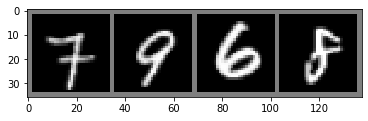

    7     9     6     8


In [59]:
vis_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)

dataiter = iter(vis_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#3. Network crafting

In [0]:
# G(z, y)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        # z
        self.deconv1_1 = nn.ConvTranspose2d(100, d*2, 4, 1, 0)
        self.deconv1_1_bn = nn.BatchNorm2d(d*2)
        # y
        self.deconv1_2 = nn.ConvTranspose2d(10, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        # concat_
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)

        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)

        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(input)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], 1)

        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))

        x = F.tanh(self.deconv4(x))

        # tensor(1, 128, 128)
        return x

In [0]:
# D(x, y)
class discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        # x
        self.conv1_1 = nn.Conv2d(1, int(d/2), 4, 2, 1)
        # y
        self.conv1_2 = nn.Conv2d(10, int(d/2), 4, 2, 1)
        # concat_
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)

        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)

        self.conv4 = nn.Conv2d(d * 4, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input, label):
        x = F.leaky_relu(self.conv1_1(input), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)

        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)

        x = F.sigmoid(self.conv4(x))
        # tensor(1)
        return x

#+Helper functions

In [0]:
def show_result(num_epoch, show = False, save = False, path = 'result.png'):
  # model.eval() will notify all your layers that you are in eval mode
  # torch.no_grad() impacts the autograd engine and deactivate it
  G.eval()
  test_images = G(fixed_z_, fixed_y_label_)
  # By default all the modules are initialized to train mode
  G.train()

  size_figure_grid = 10
  fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
  
  for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
    ax[i, j].get_xaxis().set_visible(False)
    ax[i, j].get_yaxis().set_visible(False)

  for k in range(10*10):
    i = k // 10
    j = k % 10
    ax[i, j].cla()
    ax[i, j].imshow(test_images[k, 0].cpu().data.numpy(), cmap='gray')

  label = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0.04, label, ha='center')
  plt.savefig(path)

  if show:
    plt.show()
  else:
    plt.close()

def show_train_hist(hist, show = False, save = False, path = 'Train_hist.png'):
  x = range(len(hist['D_losses']))

  y1 = hist['D_losses']
  y2 = hist['G_losses']

  plt.plot(x, y1, label='D_loss')
  plt.plot(x, y2, label='G_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.legend(loc=4)
  plt.grid(True)
  plt.tight_layout()

  if save:
    plt.savefig(path)

  if show:
    plt.show()
  else:
    plt.close()

#4. Training

In [85]:
# Fixed noise(Latent vector)
temp_z_ = torch.randn(10, 100)  # tensor(10, 100)
fixed_z_ = temp_z_
# Label
fixed_y_ = torch.zeros(10, 1) # tensor(10, 1)

for i in range(9):
    fixed_z_ = torch.cat([fixed_z_, temp_z_], dim=0)
    temp = torch.ones(10, 1) + i  # tensor(10, 1) + 1, 2, ..., 9
    fixed_y_ = torch.cat([fixed_y_, temp], dim=0)

# fixed_z_ ([100, 100])
# fixed_y_ ([100, 1])

fixed_z_ = fixed_z_.view(-1, 100, 1, 1)
# fixed_z_ ([100, 100, 1, 1])

fixed_y_label_ = torch.zeros(100, 10)
fixed_y_label_.scatter_(1, fixed_y_.type(torch.LongTensor), 1)
# fixed_y_label_ ([100, 10])

fixed_y_label_ = fixed_y_label_.view(-1, 10, 1, 1)
# fixed_y_label_ ([100, 10, 1, 1])
fixed_z_, fixed_y_label_ = Variable(fixed_z_.cuda(), volatile=True), Variable(fixed_y_label_.cuda(), volatile=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [0]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [0]:
# network
G = generator(d=128)
D = discriminator(d=128)

G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

G.cuda()
D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=Config.lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=Config.lr, betas=(0.5, 0.999))

In [95]:
# Results save folder
root = 'MNIST_results/'
model = 'MNIST_cDCGAN_'

if not os.path.isdir(root):
    os.mkdir(root)
if not os.path.isdir(root + 'Fixed_results'):
    os.mkdir(root + 'Fixed_results')

train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []

# Label preprocess
onehot = torch.zeros(10, 10)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
fill = torch.zeros([10, 10, Config.img_size, Config.img_size])

for i in range(10):
    fill[i, i, :, :] = 1

print('training start!')
start_time = time.time()
for epoch in range(Config.train_epoch):
    D_losses = []
    G_losses = []

    # lr decay
    if (epoch+1) == 11:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    if (epoch+1) == 16:
        G_optimizer.param_groups[0]['lr'] /= 10
        D_optimizer.param_groups[0]['lr'] /= 10
        print("learning rate change!")

    epoch_start_time = time.time()
    y_real_ = torch.ones(Config.batch_size)
    y_fake_ = torch.zeros(Config.batch_size)
    y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())

    for x_, y_ in train_loader:
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        if mini_batch != Config.batch_size:
            y_real_ = torch.ones(mini_batch)
            y_fake_ = torch.zeros(mini_batch)
            y_real_, y_fake_ = Variable(y_real_.cuda()), Variable(y_fake_.cuda())

        y_fill_ = fill[y_]
        x_, y_fill_ = Variable(x_.cuda()), Variable(y_fill_.cuda())

        D_result = D(x_, y_fill_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).squeeze()
        y_label_ = onehot[y_]
        y_fill_ = fill[y_]
        z_, y_label_, y_fill_ = Variable(z_.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_fill_).squeeze()

        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_fake_score = D_result.data.mean()

        D_train_loss = D_real_loss + D_fake_loss

        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1)
        y_ = (torch.rand(mini_batch, 1) * 10).type(torch.LongTensor).squeeze()
        y_label_ = onehot[y_]
        y_fill_ = fill[y_]
        z_, y_label_, y_fill_ = Variable(z_.cuda()), Variable(y_label_.cuda()), Variable(y_fill_.cuda())

        G_result = G(z_, y_label_)
        D_result = D(G_result, y_fill_).squeeze()

        G_train_loss = BCE_loss(D_result, y_real_)

        G_train_loss.backward()
        G_optimizer.step()

        G_losses.append(G_train_loss.item())

    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), Config.train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    fixed_p = root + 'Fixed_results/' + model + str(epoch + 1) + '.png'
    show_result((epoch+1), save=True, path=fixed_p)
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

end_time = time.time()
total_ptime = end_time - start_time
train_hist['total_ptime'].append(total_ptime)

print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), Config.train_epoch, total_ptime))
print("Training finish!... save training results")
torch.save(G.state_dict(), root + model + 'generator_param.pkl')
torch.save(D.state_dict(), root + model + 'discriminator_param.pkl')
with open(root + model + 'train_hist.pkl', 'wb') as f:
    pickle.dump(train_hist, f)

show_train_hist(train_hist, save=True, path=root + model + 'train_hist.png')

images = []
for e in range(Config.train_epoch):
    img_name = root + 'Fixed_results/' + model + str(e + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave(root + model + 'generation_animation.gif', images, fps=5)

training start!


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


[1/20] - ptime: 176.54, loss_d: 1.075, loss_g: 1.602
[2/20] - ptime: 176.67, loss_d: 1.126, loss_g: 1.438
[3/20] - ptime: 176.76, loss_d: 1.068, loss_g: 1.498
[4/20] - ptime: 176.59, loss_d: 0.997, loss_g: 1.599
[5/20] - ptime: 176.58, loss_d: 0.886, loss_g: 1.773
[6/20] - ptime: 176.51, loss_d: 0.777, loss_g: 1.990
[7/20] - ptime: 176.65, loss_d: 0.653, loss_g: 2.327
[8/20] - ptime: 176.52, loss_d: 0.504, loss_g: 2.649
[9/20] - ptime: 176.67, loss_d: 0.443, loss_g: 3.026
[10/20] - ptime: 176.55, loss_d: 0.311, loss_g: 3.323
learning rate change!
[11/20] - ptime: 176.49, loss_d: 0.144, loss_g: 3.100
[12/20] - ptime: 176.55, loss_d: 0.143, loss_g: 3.152
[13/20] - ptime: 176.58, loss_d: 0.129, loss_g: 3.227
[14/20] - ptime: 176.53, loss_d: 0.115, loss_g: 3.310
[15/20] - ptime: 176.70, loss_d: 0.107, loss_g: 3.490
learning rate change!
[16/20] - ptime: 176.55, loss_d: 0.095, loss_g: 3.519
[17/20] - ptime: 176.59, loss_d: 0.093, loss_g: 3.580
[18/20] - ptime: 176.61, loss_d: 0.090, loss_g:

#5. Saving the model and Loading...

In [96]:
# Print model's state_dict
print("Generator's state_dict:")
for param_tensor in G.state_dict():
  print(param_tensor, "\t", G.state_dict()[param_tensor].size())
print("=========================================================")
print("Discriminator's state_dict:")
for param_tensor in D.state_dict():
  print(param_tensor, "\t", D.state_dict()[param_tensor].size())


# Print optimizer's state_dict
print("G_Optimizer's state_dict:")
for var_name in G_optimizer.state_dict():
    print(var_name, "\t", G_optimizer.state_dict()[var_name])
print("=========================================================")
print("D_Optimizer's state_dict:")
for var_name in D_optimizer.state_dict():
    print(var_name, "\t", D_optimizer.state_dict()[var_name])

Generator's state_dict:
deconv1_1.weight 	 torch.Size([100, 256, 4, 4])
deconv1_1.bias 	 torch.Size([256])
deconv1_1_bn.weight 	 torch.Size([256])
deconv1_1_bn.bias 	 torch.Size([256])
deconv1_1_bn.running_mean 	 torch.Size([256])
deconv1_1_bn.running_var 	 torch.Size([256])
deconv1_1_bn.num_batches_tracked 	 torch.Size([])
deconv1_2.weight 	 torch.Size([10, 256, 4, 4])
deconv1_2.bias 	 torch.Size([256])
deconv1_2_bn.weight 	 torch.Size([256])
deconv1_2_bn.bias 	 torch.Size([256])
deconv1_2_bn.running_mean 	 torch.Size([256])
deconv1_2_bn.running_var 	 torch.Size([256])
deconv1_2_bn.num_batches_tracked 	 torch.Size([])
deconv2.weight 	 torch.Size([512, 256, 4, 4])
deconv2.bias 	 torch.Size([256])
deconv2_bn.weight 	 torch.Size([256])
deconv2_bn.bias 	 torch.Size([256])
deconv2_bn.running_mean 	 torch.Size([256])
deconv2_bn.running_var 	 torch.Size([256])
deconv2_bn.num_batches_tracked 	 torch.Size([])
deconv3.weight 	 torch.Size([256, 128, 4, 4])
deconv3.bias 	 torch.Size([128])
deconv

- Save/Load Entire Model

In [105]:
# Saving
torch.save(G, './save/' + "G_MNIST_test_model.pth")
torch.save(D, './save/' + "D_MNIST_test_model.pth")

# Loading (Model class must be defined somewhere)
'''
net = torch.load(Config.saving_dir)
net.eval()
'''

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConvTranspose2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/loc

'\nnet = torch.load(Config.saving_dir)\nnet.eval()\n'